In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import math

In [2]:
def graph_json(filename):
    with open(filename) as json_file:
        json_data = json.load(json_file)
        name = json_data['ObjectName']
        seed = json_data['Seed']
        vertex_count = json_data['VertexCount']
        sampling_rate = json_data['SamplingRate']
        deformed_deviation = json_data['DeformedAngularDeviation']
        deformation_method = json_data['DeformationMethod']
        vertex_selection_method = json_data['VertexSelectionMethod']
        offsets = np.array(json_data['Offsets'], dtype='float')
        vertices = np.array(json_data['Vertices'], dtype='int')
        skipped_iterations = np.array(json_data['SkippedIterations'], dtype='bool')
        ideal_normal_angles_from_ray = np.array(json_data['IdealNormalAnglesFromRay'], dtype='float')
        iterations = vertices.size
        deviations = np.array(json_data['Deviations'], dtype='float').reshape((iterations, offsets.size))
        current_deviations = np.array(json_data['CurrentDeviations'], dtype=float)

        min_deviation = np.min(deviations[-1])
        max_deviation = np.max(deviations)
        min_offset = np.round(np.min(offsets), 2)
        max_offset = np.round(np.max(offsets), 2)
        effective_iterations = iterations - np.sum(skipped_iterations)

        deviation_diff_percent = (min_deviation-deformed_deviation)/deformed_deviation * 100

        xplots = 10
        yplots = math.ceil(iterations/xplots)
        # Limit the amount of y plots into a nice square
        yplots = min(yplots, xplots)
        figsize_multiplier = 4
        fig, axs = plt.subplots(yplots, xplots, figsize=(xplots*figsize_multiplier, yplots*figsize_multiplier))

        info = f"Plot of total angular deviation (0; {np.round(max_deviation,2)}) per offset ({min_offset}; {max_offset}), sampled every {sampling_rate}\n"
        info += f"Object: {name}\n"
        info += f"Vertices: {vertex_count} (if more vertices then expected, that is because of UV mapping)\n"
        info += f"Deformation method: {deformation_method}"
        if (deformation_method == "Random"):
            info += f" (seed {seed})"
        info += f"\n"
        info += f"Vertex selection method: {vertex_selection_method}\n"
        info += f"First {min(xplots*yplots, iterations)}/{iterations} iterations plotted ltr-ttb. {effective_iterations} iterations ({np.round(effective_iterations/iterations*100, 2)}%) reduced the minimum\n"
        info += f"Total angular deviation reduced from {np.round(deformed_deviation, 2)} to {np.round(min_deviation, 2)} ({np.round(deviation_diff_percent, 2)}%)\n"
        info += f"\nLEGEND\n"
        info += f"-------------\n"
        info += f"v: Current iteration's vertex\n"
        info += f"ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint\n"
        info += f"cd: Current deviation\n"
        info += f"md: Minimum deviation of iteration\n"
        info += f"off: offset that corresponds to the (discrete) minimum\n"
        print(info)

        for y in range(yplots):
            for x in range(xplots):
                iter = y*xplots + x
                if iter < iterations:
                    # Plot the discrete data
                    color = 'red' if skipped_iterations[iter] else 'blue'
                    axs[y,x].plot(offsets, deviations[iter], c=color)

                    # Plot the deviation it should be lower than
                    axs[y,x].axhline(y=current_deviations[iter], color='black', linewidth=0.5)

                    # Plot the quadratically fitted approximation of the data
                    min_dev_offset_index = np.argmin(deviations[iter])
                    # Exclude the minimum offset from each side
                    exclusion_width=0
                    left_end = min_dev_offset_index - exclusion_width
                    right_start = min_dev_offset_index + 1 - exclusion_width
                    left_offsets = offsets[0:left_end]
                    left_deviations = deviations[iter][0:left_end]
                    right_offsets = offsets[right_start:]
                    right_deviations = deviations[iter][right_start:]

                    model = np.poly1d(np.polyfit(offsets, deviations[iter], 2))
                    left_model = np.poly1d(np.polyfit(left_offsets, left_deviations, 2))
                    right_model = np.poly1d(np.polyfit(right_offsets, right_deviations, 2))
                    axs[y,x].plot(offsets, model(offsets), color='magenta')
                    axs[y,x].plot(offsets, left_model(offsets), color='black')
                    axs[y,x].plot(offsets, right_model(offsets), color='green')

                    # Make the title
                    vertex = vertices[iter]
                    title = f"v: {vertex}"
                    title += f"\nndfr: {np.round(ideal_normal_angles_from_ray[vertex],1)}"
                    title += f"\ncd: {np.round(current_deviations[iter], 3)}"
                    title += f"\nmd: {np.round(deviations[iter, min_dev_offset_index], 3)}"
                    title += f"\noff: {np.round(offsets[min_dev_offset_index], 3)}"
                    axs[y,x].set_title(title)

                # Set the axes invisible
                axs[y,x].set_ylim(0, max_deviation)
                axs[y,x].set_xticklabels([])
                axs[y,x].set_yticklabels([])
        
        fig.tight_layout()
        fig.show()

Plot of total angular deviation (0; 1325.71) per offset (-10.0; 9.99), sampled every 0.009999999776482582
Object: Tetrahedron
Vertices: 12 (if more vertices then expected, that is because of UV mapping)
Deformation method: Random (seed 0)
Vertex selection method: Maximum local angular deviation, skipping if no decrease in total deviation
First 100/186 iterations plotted ltr-ttb. 42 iterations (22.58%) reduced the minimum
Total angular deviation reduced from 96.37 to 1.45 (-98.5%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_69051/1853099754.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


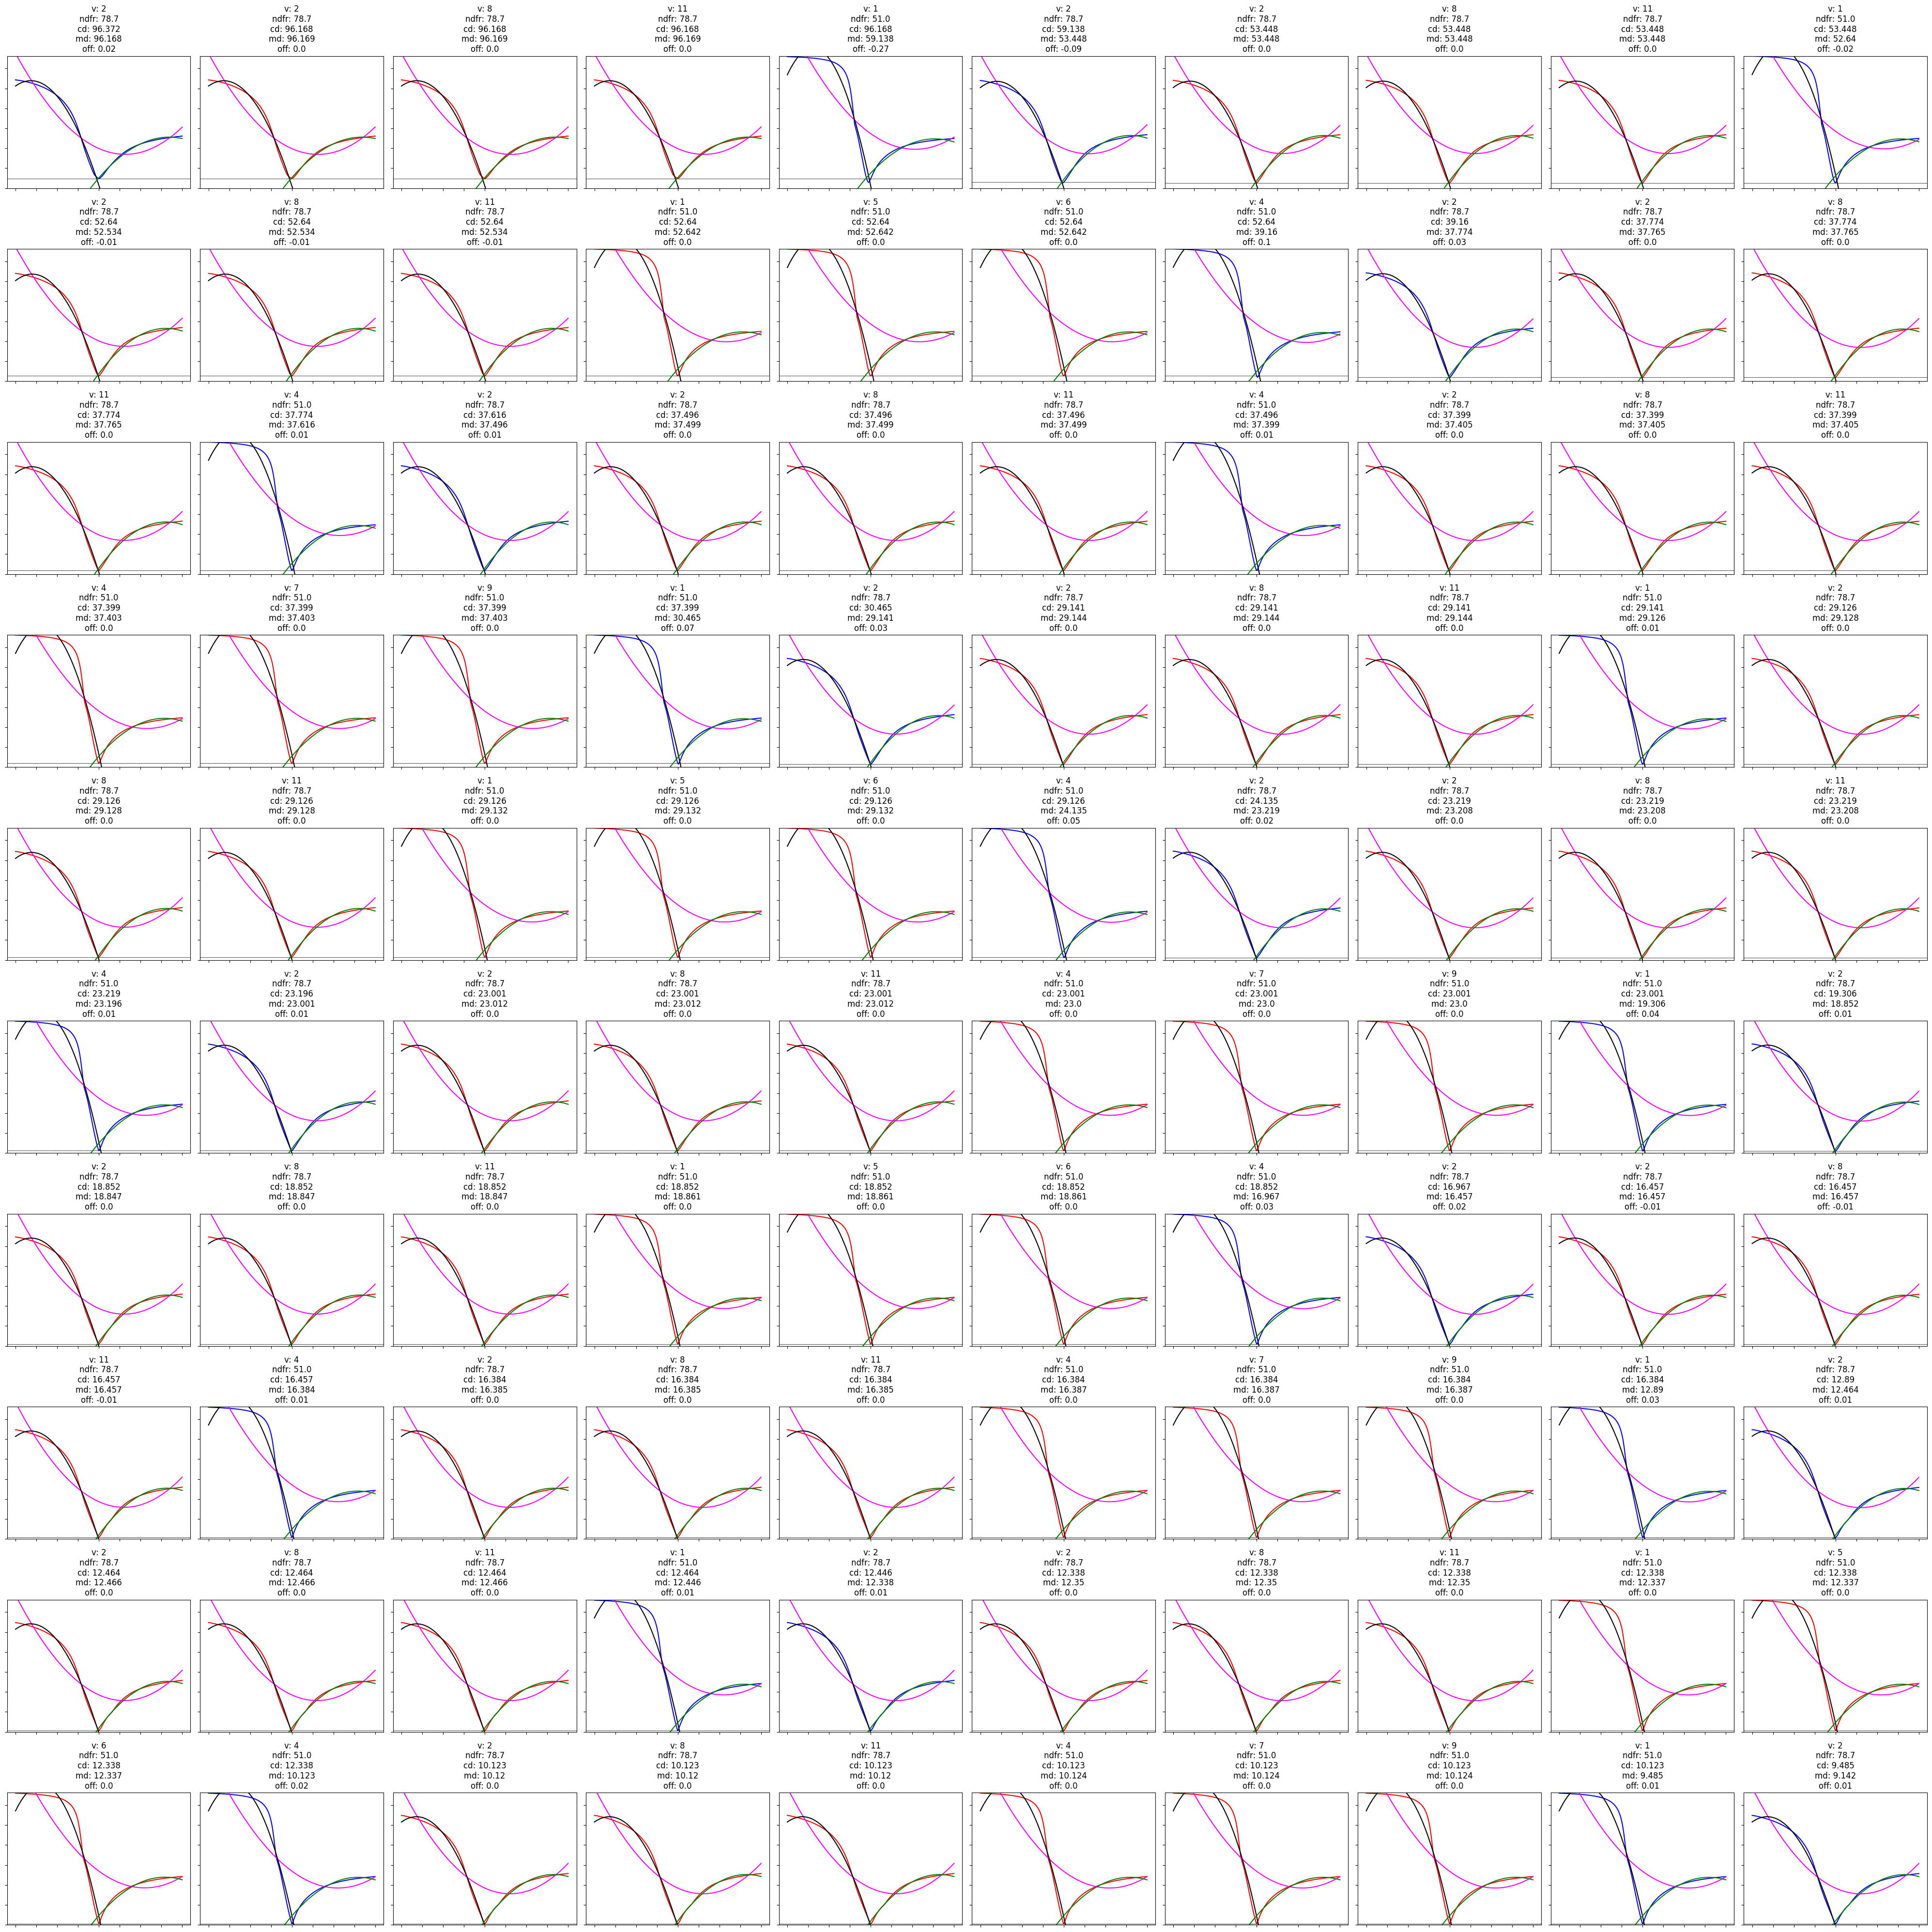

In [3]:
graph_json("Tetrahedron.json")

Plot of total angular deviation (0; 1367.1) per offset (-10.0; 9.99), sampled every 0.009999999776482582
Object: Cube
Vertices: 24 (if more vertices then expected, that is because of UV mapping)
Deformation method: Random (seed 0)
Vertex selection method: Maximum local angular deviation, skipping if no decrease in total deviation
First 100/314 iterations plotted ltr-ttb. 54 iterations (17.2%) reduced the minimum
Total angular deviation reduced from 123.66 to 1.89 (-98.47%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_69051/1853099754.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


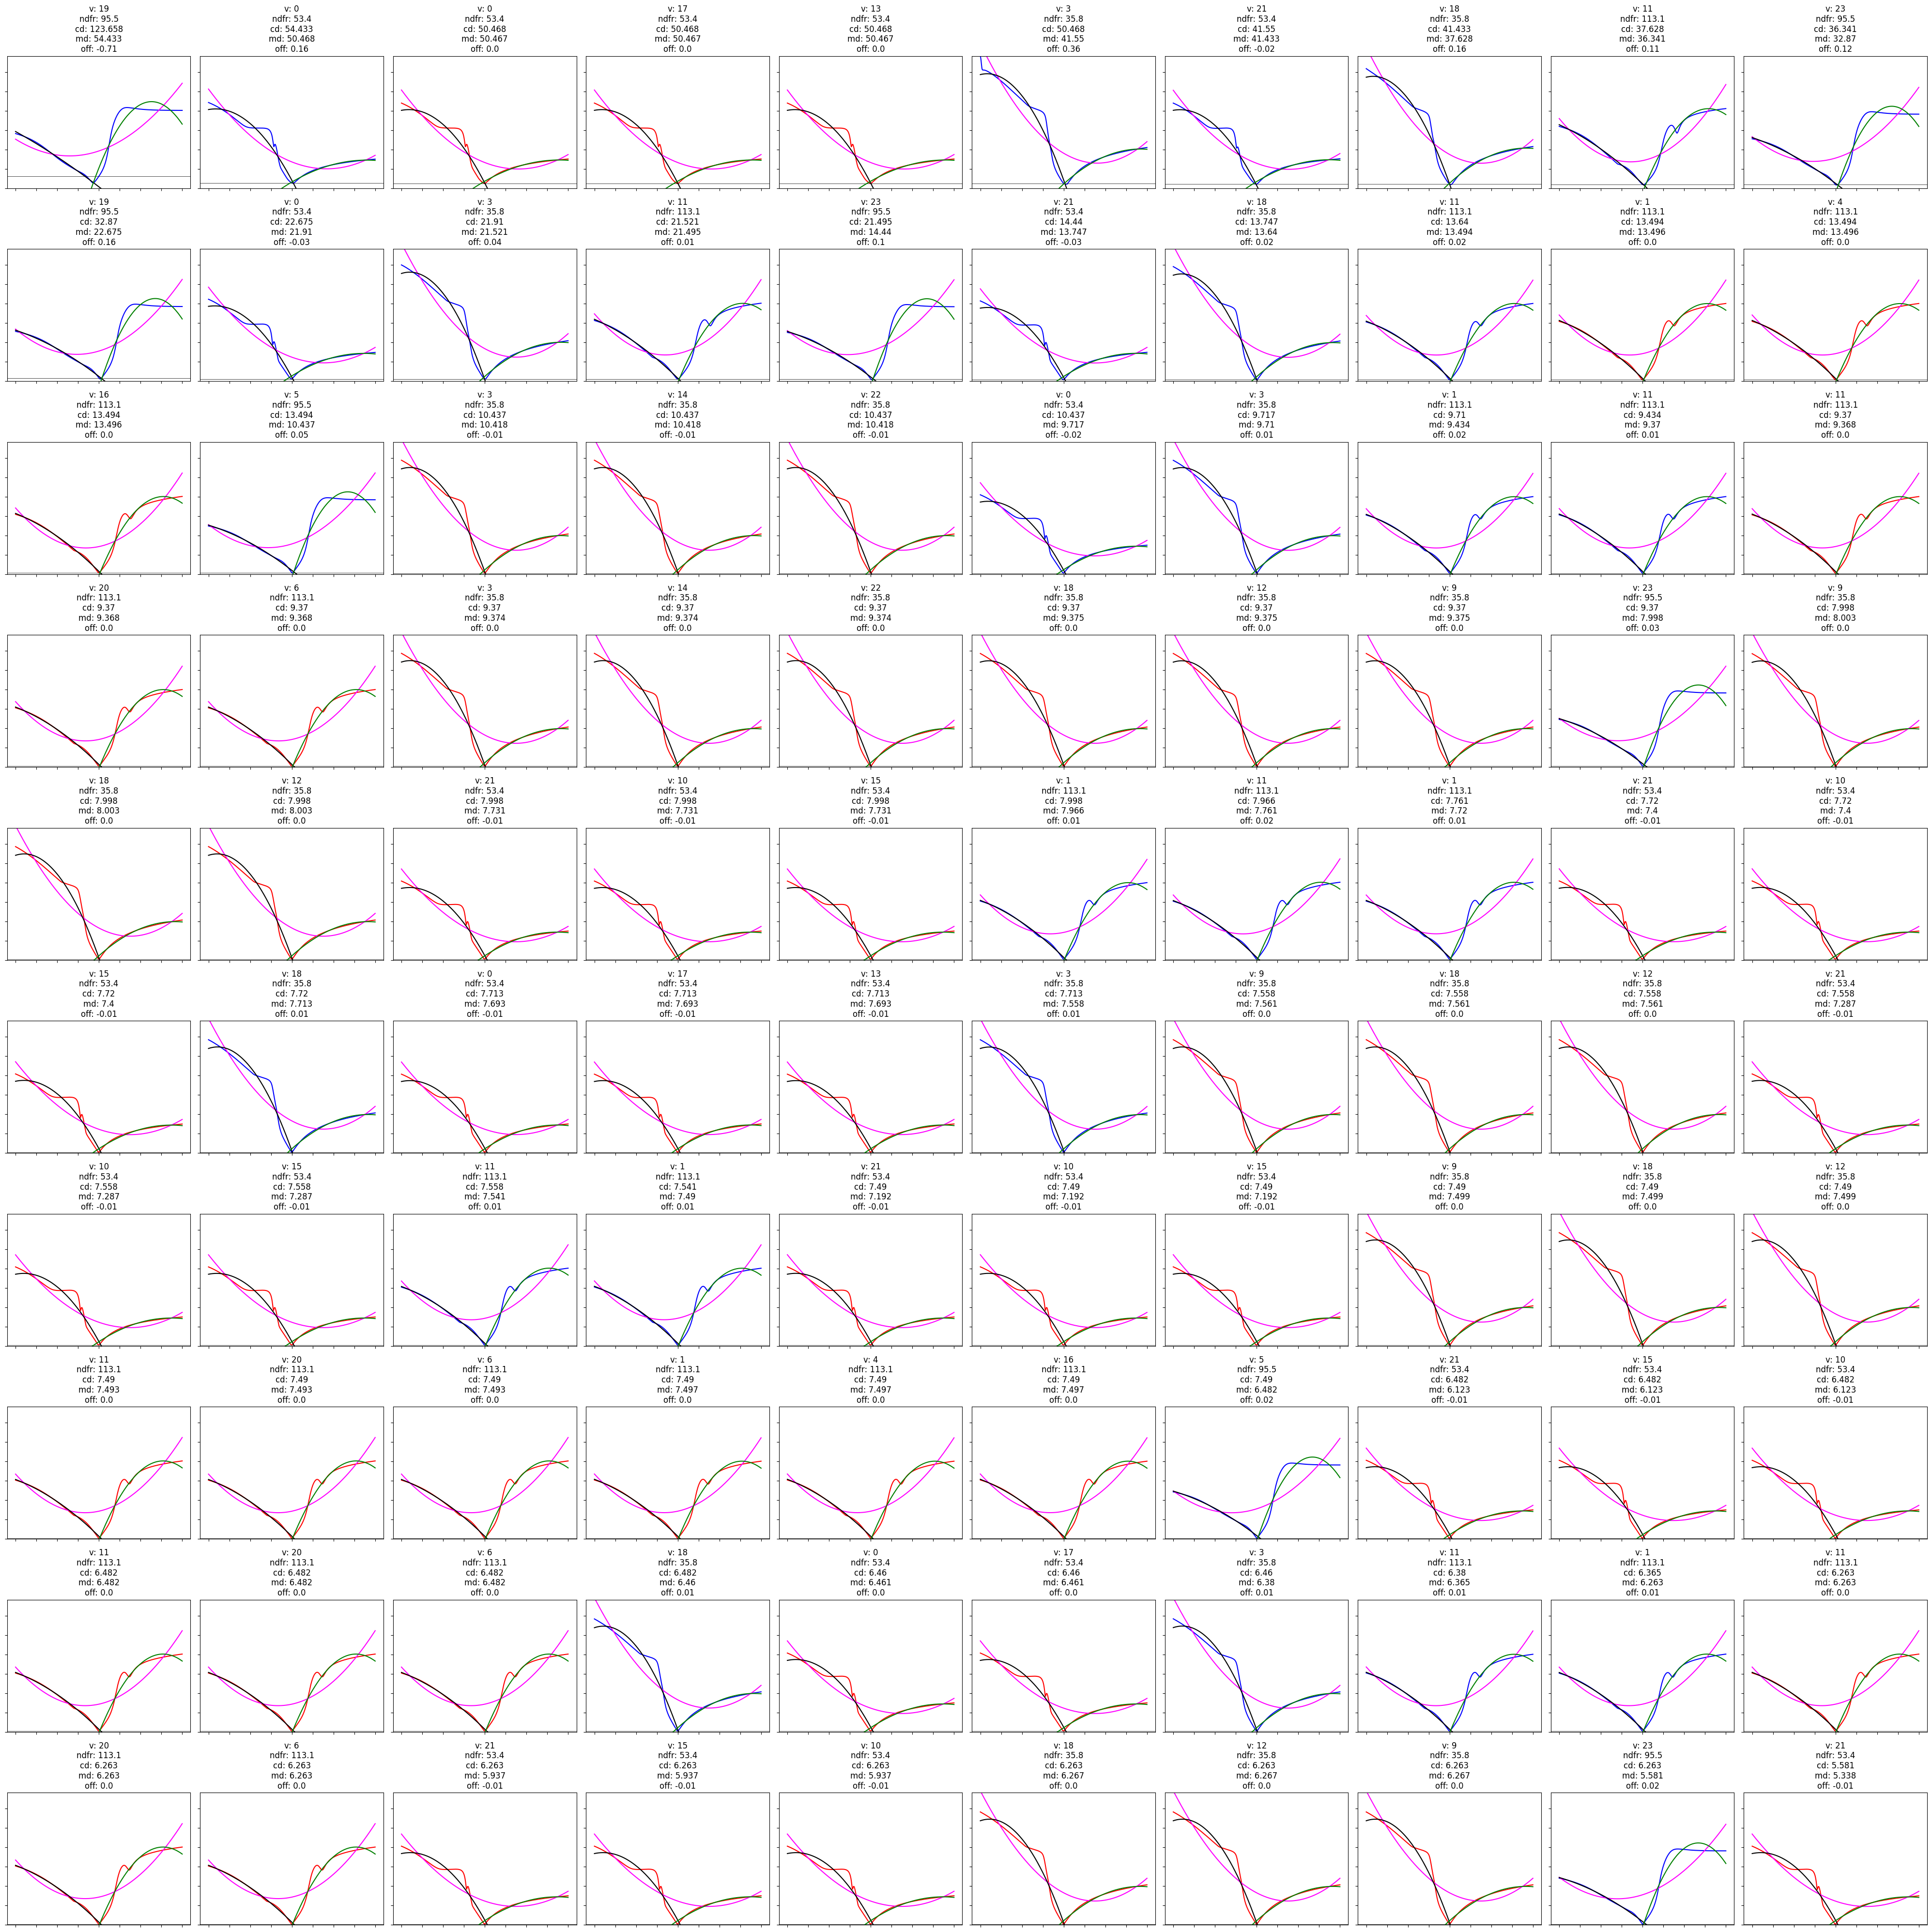

In [4]:
graph_json("Cube.json")

Plot of total angular deviation (0; 2395.97) per offset (-10.0; 9.99), sampled every 0.009999999776482582
Object: Icosahedron
Vertices: 60 (if more vertices then expected, that is because of UV mapping)
Deformation method: Random (seed 0)
Vertex selection method: Maximum local angular deviation, skipping if no decrease in total deviation
First 100/850 iterations plotted ltr-ttb. 50 iterations (5.88%) reduced the minimum
Total angular deviation reduced from 733.05 to 201.32 (-72.54%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_69051/1853099754.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


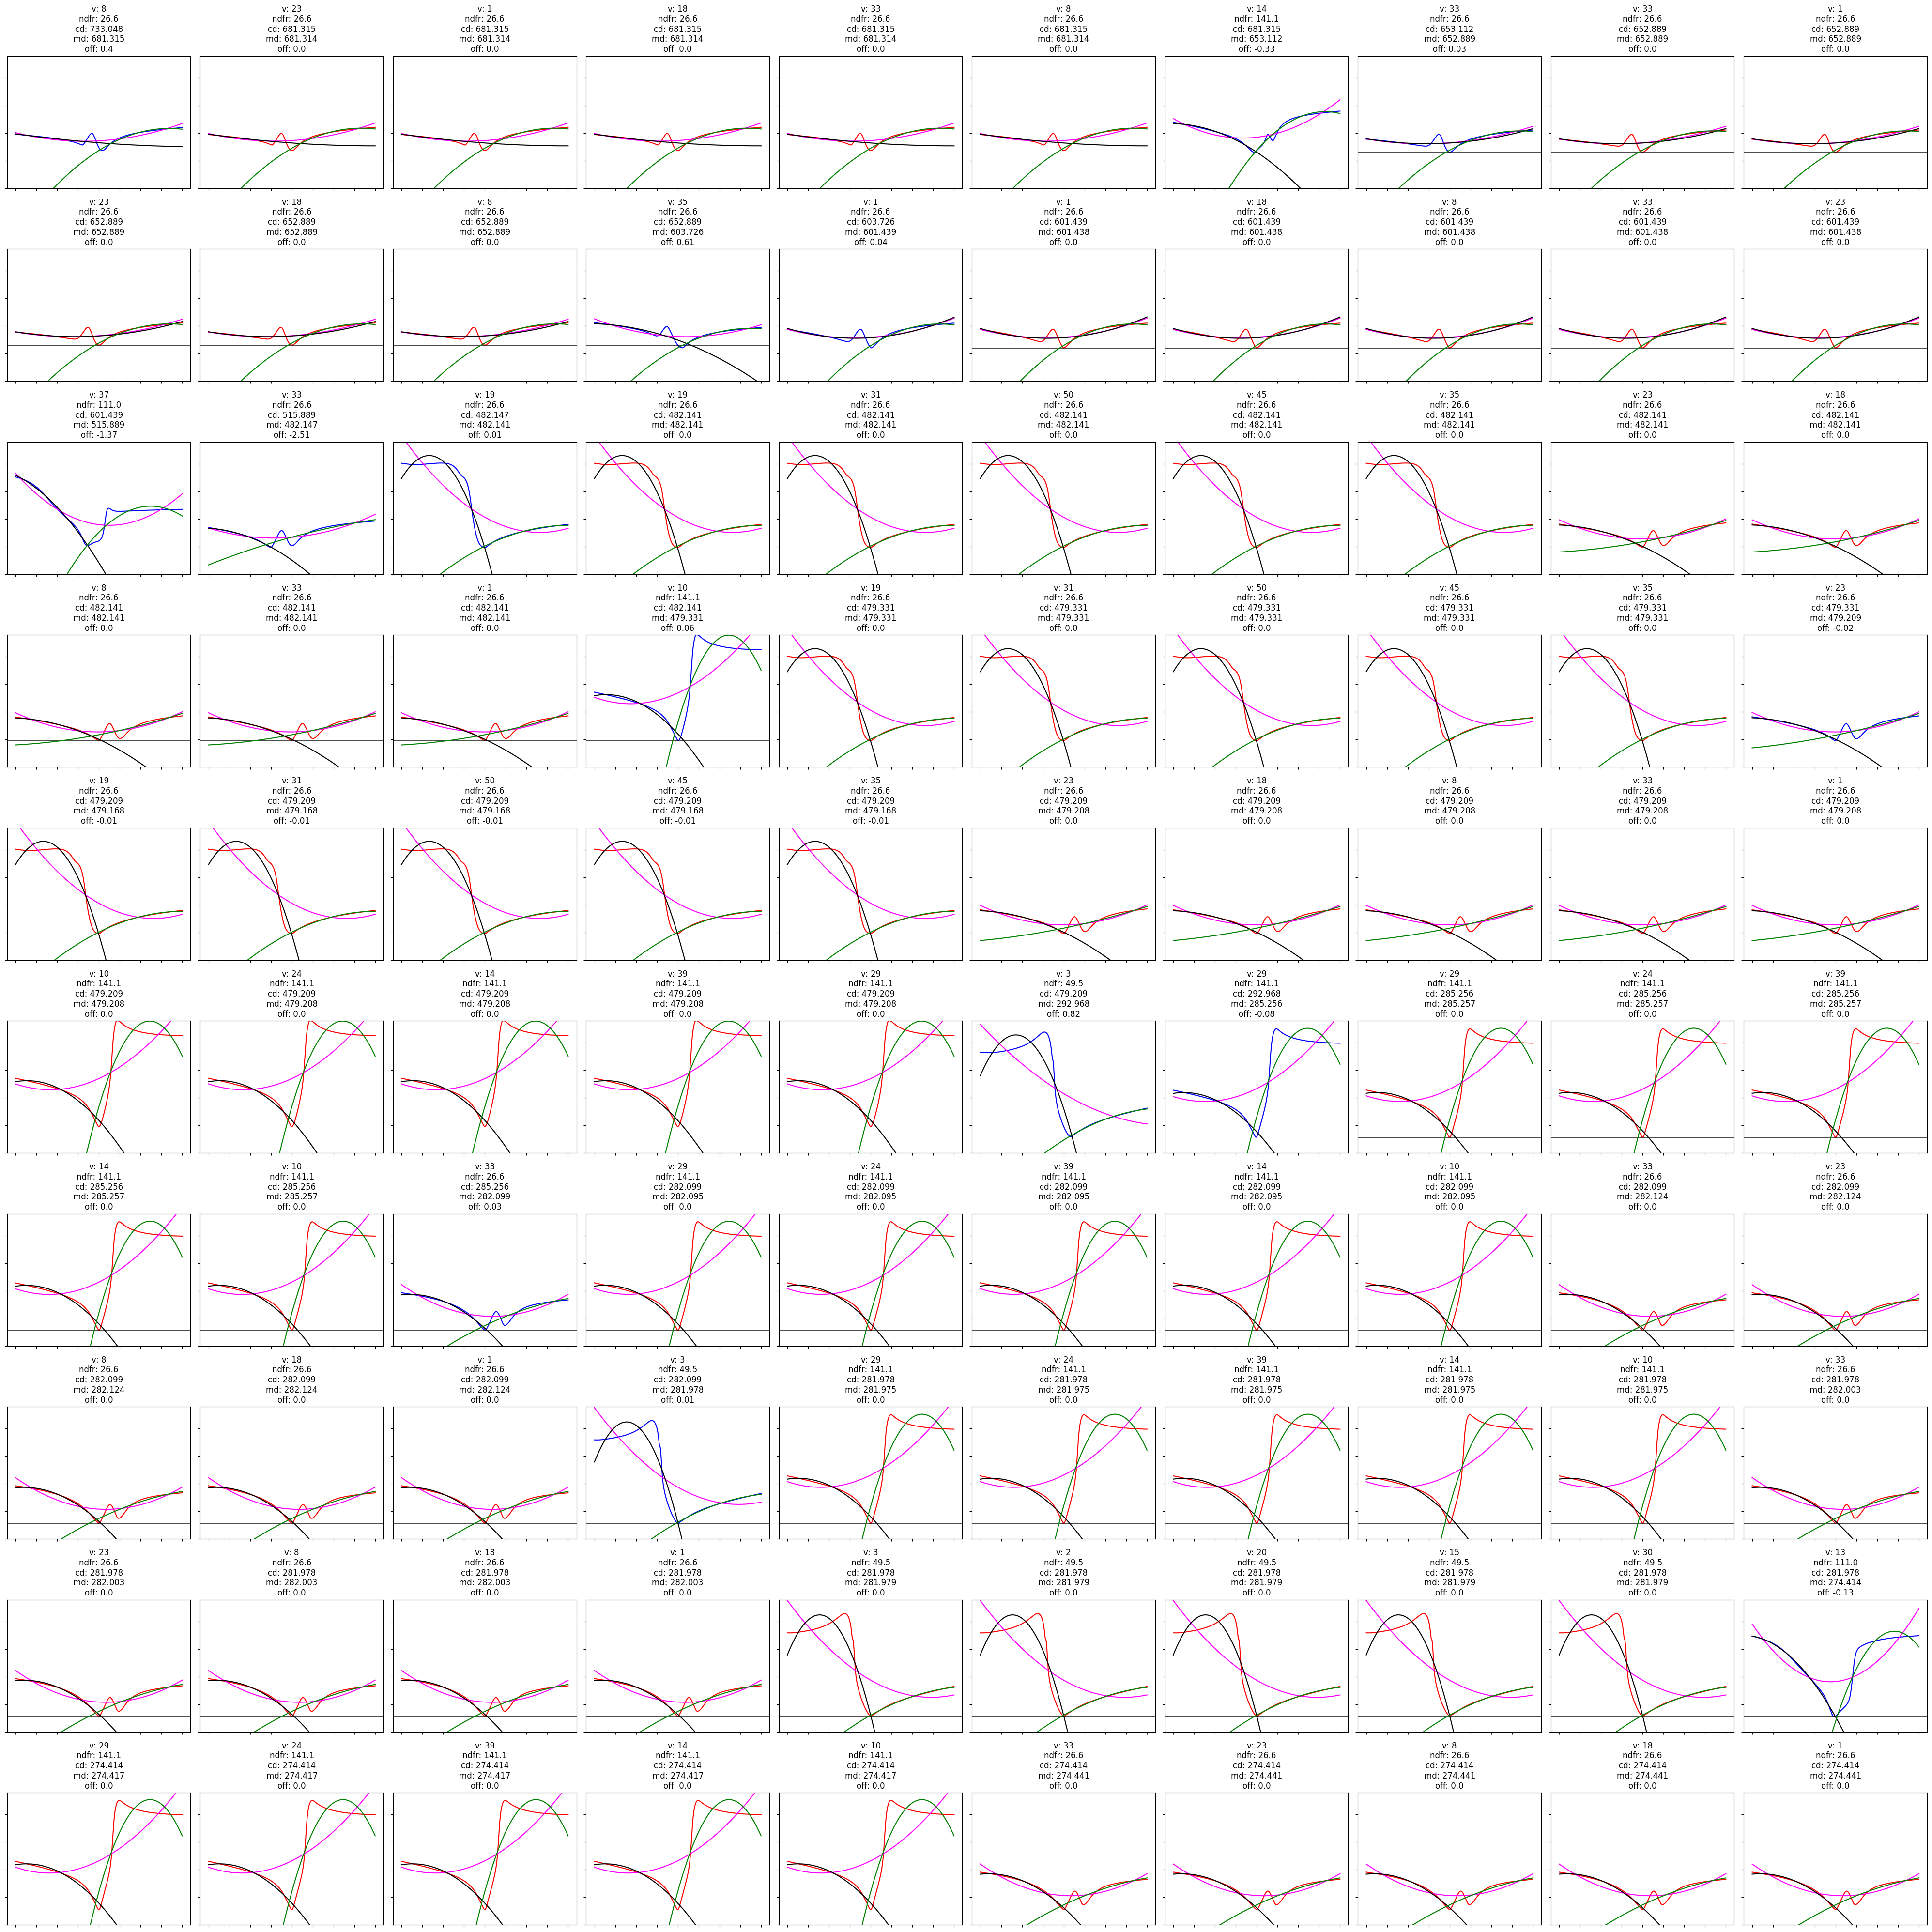

In [5]:
graph_json("Icosahedron.json")